# K - clustering for edge devices
## Tables of contents
### 1.Feature Definition and Data Collection
- Select measurable features suitable for edge devices .
- Collect data from devices or public datasets.
- Normalize and store data efficiently for limited hardware.
### 2. K-Means Classification on Edge Devices
- Implement a lightweight K-Means algorithm optimized for CPU/GPU constraints.
- Data Standardization.
- Finding Optimal Number of Clusters
  + Elbow Method.
  + Silhouette Score.
- PCA for Visualization.
- Saving and Exporting Results.
- Demonstration: Mango classification using the [dataset](https://www.kaggle.com/code/muhammadmuzammil196/k-mean-mangoes-clustering).
### 3. Integration with Split Inference
- Extract features on the edge device to minimize bandwidth.
- Perform clustering locally for real-time classification.
- Offload model retraining to the cloud.
- Synchronize updated cluster centers back to devices with minimal data transfer.


### 1. Define feature and collect data

### 2. Build algorithm

In [1]:
# ==========================================================
# 1. IMPORT LIBRARIES
# ==========================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from IPython.display import display, Markdown


In [3]:
# ==========================================================
# 2. LOAD DATA
# ==========================================================
df = pd.read_csv("mango2.csv")
display(Markdown("###  Dữ liệu đầu vào"))
display(df.head())
print(df.shape)


###  Dữ liệu đầu vào

,GreenMango Length,GreenMangowidth,YelloMangoLength,YelloMangoWidth
0,10.2,10.5,5.6,0.6
1,9.8,9.0,5.6,0.6
2,9.4,9.6,5.2,0.6
3,9.2,9.3,6.0,0.6
4,10.0,10.8,5.6,0.6


(151, 4)


In [4]:
# ==========================================================
# 3. TIỀN XỬ LÝ (XỬ LÝ NA, LỌC CỘT SỐ)
# ==========================================================
df = df.dropna()

# Lấy các cột dạng numeric để phân cụm
num_df = df.select_dtypes(include=[np.number])

display(Markdown("###  Dữ liệu số dùng để phân cụm"))
display(num_df.head())


###  Dữ liệu số dùng để phân cụm

,GreenMango Length,GreenMangowidth,YelloMangoLength,YelloMangoWidth
0,10.2,10.5,5.6,0.6
1,9.8,9.0,5.6,0.6
2,9.4,9.6,5.2,0.6
3,9.2,9.3,6.0,0.6
4,10.0,10.8,5.6,0.6


In [5]:
# ==========================================================
# 4. CHUẨN HÓA (VERY IMPORTANT FOR K-MEANS)
# ==========================================================
scaler = StandardScaler()
X = scaler.fit_transform(num_df)


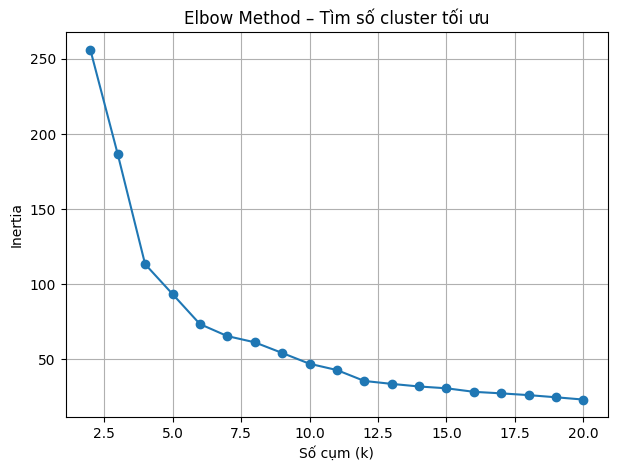

In [6]:
# ==========================================================
# 5. TÌM SỐ CLUSTER TỐI ƯU (ELBOW METHOD)
# ==========================================================
inertias = []
K = range(2, 21)

for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X)
    inertias.append(km.inertia_)

plt.figure(figsize=(7,5))
plt.plot(K, inertias, marker='o')
plt.title("Elbow Method – Tìm số cluster tối ưu")
plt.xlabel("Số cụm (k)")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()


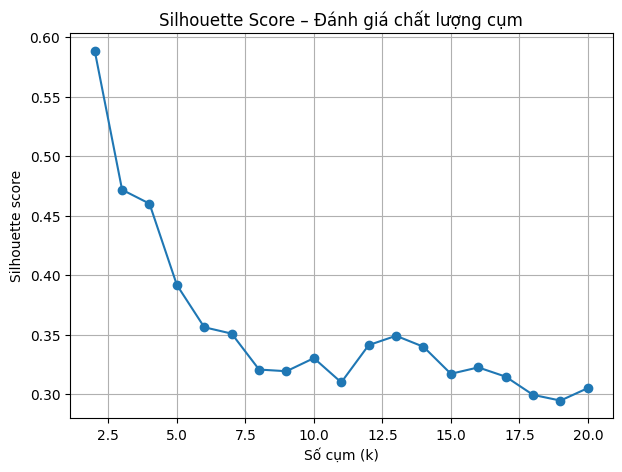

In [8]:
# ==========================================================
# 6. SILHOUETTE SCORE – KIỂM TRA CHẤT LƯỢNG CỤM
# ==========================================================
sil_scores = []

for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X)
    sil = silhouette_score(X, labels)
    sil_scores.append(sil)

plt.figure(figsize=(7,5))
plt.plot(K, sil_scores, marker='o')
plt.title("Silhouette Score – Đánh giá chất lượng cụm")
plt.xlabel("Số cụm (k)")
plt.ylabel("Silhouette score")
plt.grid(True)
plt.show()


In [9]:
# ==========================================================
# 7. CHỌN K TỐI ƯU
# (Tự động lấy k có silhouette cao nhất)
# ==========================================================
best_k = K[np.argmax(sil_scores)]
best_k


2

In [10]:
# ==========================================================
# 8. TRAIN K-MEANS VỚI K TỐI ƯU
# ==========================================================
kmeans = KMeans(n_clusters=best_k, random_state=42)
clusters = kmeans.fit_predict(X)

df["Cluster"] = clusters

display(Markdown(f"###  Số cụm tối ưu: **{best_k}**"))
display(df.head())


###  Số cụm tối ưu: **2**

,GreenMango Length,GreenMangowidth,YelloMangoLength,YelloMangoWidth,Cluster
0,10.2,10.5,5.6,0.6,1
1,9.8,9.0,5.6,0.6,1
2,9.4,9.6,5.2,0.6,1
3,9.2,9.3,6.0,0.6,1
4,10.0,10.8,5.6,0.6,1


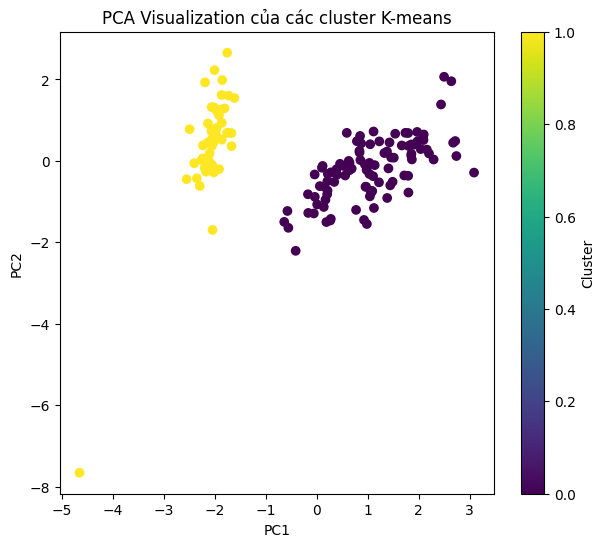

In [29]:
# ==========================================================
# 9. VISUALIZE PCA 2D
# ==========================================================
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(7,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')
plt.title("PCA Visualization của các cluster K-means")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cluster")
plt.show()


In [11]:
# ==========================================================
# 10. LƯU KẾT QUẢ
# ==========================================================
df.to_csv("mango2_clustered.csv", index=False)
print("Đã lưu file: mango2_clustered.csv")


Đã lưu file: mango2_clustered.csv
